### Config

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import sys
import torch
PROJ_ROOT = os.path.dirname(os.getcwd())
sys.path.append(PROJ_ROOT)

TEST_NAME = "lion_close"
OBJ_NAME = "lion"
UPSCALE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

DATASPACE_DIR = os.path.join(PROJ_ROOT, 'dataspace')
REFERENCES_DIR = os.path.join(PROJ_ROOT, "demo_data", "references")
MASK_PATH = os.path.join(PROJ_ROOT, "demo_data", "tests", TEST_NAME, f"{TEST_NAME}.png")
PIXELTRACKER_RESULTS_PATH = os.path.join(PROJ_ROOT, "demo_data", "tests", TEST_NAME, f"{TEST_NAME}_spatracker_tracks.npy")
VIDEO_DIRECTORY_PATH = os.path.abspath(os.path.join(PROJ_ROOT, 'demo_data', 'tests', TEST_NAME))

cuda


In [2]:
from dataset.inference_datasets import YCBInEOAT_Dataset
from posingpixels.alignment import PixelToGaussianAligner
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pytorch3d import io as py3d_io

from posingpixels.utils.gs_pose import create_or_load_gaussian_splat_from_images, load_model_net, load_test_data
from posingpixels.visualization import get_gaussian_splat_pointcloud, plot_pointclouds
from posingpixels.utils.gs_pose import perform_pose_estimation

model_net = load_model_net(os.path.join(PROJ_ROOT, 'checkpoints/model_weights.pth'))

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Pretrained weights are loaded from  model_weights.pth


In [3]:
mustard_dataset = YCBInEOAT_Dataset(os.path.join(DATASPACE_DIR, 'ycbineoat'), 'mustard0', load_gt_bbox=True, use_gt_mask=True, use_binarized_mask=True, degree=7)
print(mustard_dataset[2]["pose"], '\n', mustard_dataset[2]["allo_pose"])

Starting to render images for model with degree:  7
Finished rendering images for model
tensor([[ 0.4286,  0.0000, -0.9035,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.9035,  0.0000,  0.4286,  0.2947],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 
 tensor([[ 0.4286,  0.0000, -0.9035,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.9035,  0.0000,  0.4286,  0.2947],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [4]:
reference_database = create_or_load_gaussian_splat_from_images(REFERENCES_DIR, OBJ_NAME, model_net, obj_refer_dataset=mustard_dataset)

Generate object reference database for mustard_bottle ...
FPS indices:  tensor([  0,   6, 222, 109, 333,  72, 282,  37, 156, 174, 272,  54, 106, 330,
         47,  11], device='cuda:0')
[100/343], 19-18:19:52
[200/343], 19-18:19:54
[300/343], 19-18:19:56
Creating 3D-OGS model for mustard_bottle 
Output folder: /home/joao/Documents/repositories/GSPose/dataspace/ycbineoat/train/mustard_bottle-database
Reading 343  training image ...
343 training samples
-----------------------------------------
4 testing samples
----------------------------------------
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  8892


3DGO modeling progress: 100%|██████████| 30000/30000 [02:59<00:00, 167.54it/s, Loss=0.1898522]



[ITER 30000] Evaluating test: L1 0.0010357454157201573 PSNR 36.92703056335449

[ITER 30000] Evaluating train: L1 0.001010477577801794 PSNR 36.30629043579102

[ITER 30000] Saving Gaussians
save database to  /home/joao/Documents/repositories/GSPose/dataspace/ycbineoat/train/mustard_bottle-database/reference_database.pkl
Load database from  /home/joao/Documents/repositories/GSPose/dataspace/ycbineoat/train/mustard_bottle-database/reference_database.pkl
load 3D-OGS model from  /home/joao/Documents/repositories/GSPose/dataspace/ycbineoat/train/mustard_bottle-database/3DGO_model.ply


[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.29469489]
 [0.         0.         0.         1.        ]]
torch.Size([737, 3])


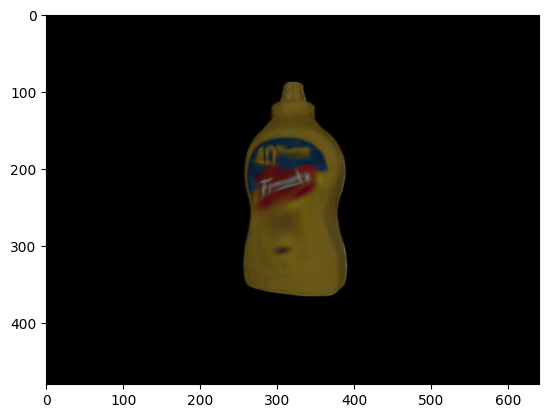

In [5]:
from posingpixels.utils.gs_pose import render_gaussian_model


mustard_gaussian_object = reference_database['obj_gaussians']
object_pointcloud = get_gaussian_splat_pointcloud(mustard_gaussian_object)
# Flip the object on the z-axis and rotate on the x-axis and y-axis by -45 degrees
R = np.array([[-1, 0, 0], [0, 0, -1], [0, -1, 0]])
# R = np.eye(3)
render = render_gaussian_model(mustard_gaussian_object, mustard_dataset.camK, 480, 640, R=R, T=np.array([0, 0, 0.3]))
plt.imshow(render)

plot_pointclouds({"Mustard": object_pointcloud}, "Mustard")
print(mustard_dataset.poses[0])
print(mustard_gaussian_object.get_scaling.shape)

### Setup

In [ ]:
# Load GS-Pose model, Gaussian object and video data
from posingpixels.utils.gs_pose import load_existing_gaussian_splat

reference_database = create_or_load_gaussian_splat_from_images(REFERENCES_DIR, OBJ_NAME, model_net)
gaussian_object = reference_database['obj_gaussians']
video, camKs = load_test_data(VIDEO_DIRECTORY_PATH)
H, W = video[0].shape[:2]

# 1. Alignment

### 1.1 First frame pose estimate

We first get a pose estimate for the first frame of the video using GS-Pose.

In [7]:
initial_pose = perform_pose_estimation(model_net, reference_database, video[:1], camKs[:1])[0][0]['track_pose']
initial_R, initial_T = initial_pose[:3, :3], initial_pose[:3, 3]

### 1.2 Initialize aligner

We then initialzie the aligner with all the information it requires: segmentation mask, pixel tracking results and settings, the gaussian splat, and the initial configuration of the pose and camera.

In [ ]:
aligner = PixelToGaussianAligner(mask_path=MASK_PATH, pixeltracker_path=PIXELTRACKER_RESULTS_PATH, pixeltracker_upscale=UPSCALE, gaussian_object=gaussian_object, initial_cam_K=camKs[0], initial_R=initial_R, initial_T=initial_T)
mask: np.ndarray = aligner.mask
frame: np.ndarray = aligner.tracks[0]

# Plot mask and overlap tracked points
plt.imshow(mask)
plt.scatter(frame[:, 0], frame[:, 1], c='r', s=1)

### 1.3 Run aligner

We now do ray intersection originating at the pixel locations with the Gaussian splat model to see what exactly those pixels are attempting to follow in the Gaussian splat.

In [ ]:
from posingpixels.utils.gs_pose import render_gaussian_model
from posingpixels.visualization import get_points_pointcloud

intersections, filtered_tracks = aligner.align()

intersections_pointcloud = get_points_pointcloud(np.array(intersections))
object_pointcloud = get_gaussian_splat_pointcloud(gaussian_object)

plot_pointclouds({"Lion": object_pointcloud, "Intersections": intersections_pointcloud}, "Aligned Pixels in Gaussian Object")

render = render_gaussian_model(gaussian_object, camKs[0], H, W, R=initial_R, T=initial_T)
plt.imshow(render)
plt.scatter(x=aligner.tracks[0][:, 0], y=aligner.tracks[0][:, 1], c='r', s=1)
plt.scatter(x=filtered_tracks[0][:, 0], y=filtered_tracks[0][:, 1], c='g', s=1)

In [ ]:
from posingpixels.optimization import MultiTimestampRenderPoseModel6D, render_train_model
import tqdm


model = MultiTimestampRenderPoseModel6D(
    points=torch.tensor(intersections, dtype=torch.float32).squeeze().to(device),
    num_timestamps=len(video),
    initial_R=initial_R,
    initial_T=initial_T,
    device=device,
)

target_points = torch.tensor(filtered_tracks, dtype=torch.float32).squeeze().to(device)
torch_camKs = torch.tensor(camKs, dtype=torch.float32).to(device)

_, predictions = render_train_model(
    model,
    torch_camKs,
    target_points,
    num_epochs=2000,
    warmup_steps=100,
    max_lr=0.02,
    early_stop_min_steps=100,
    # reconstruction_loss="l1",
    # temporal_consistency_weight=0,
    # reconstruction_loss_clip=500,
    # reconstruction_loss_clip_start_epoch=500,
)

predicted_points = predictions.detach().cpu().numpy()
predicted_poses = model.get_pose_matrices().detach().cpu().numpy()
predicted_rotations = predicted_poses[:, :3, :3]
predicted_translations = predicted_poses[:, :3, 3]
predicted_poses.shape

In [ ]:
from posingpixels.visualization import plot_per_point_losses


criterion = torch.nn.MSELoss(reduction='none')
losses = plot_per_point_losses(predictions=predicted_points[:, :, :2], target=filtered_tracks, criterion=criterion)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot "Loss of each point over time"
axs[0, 0].plot(losses)
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel(criterion.__class__.__name__)
axs[0, 0].set_title("Loss of each point over time")

# Plot "Total loss over time"
axs[0, 1].plot(losses.sum(1))
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel(criterion.__class__.__name__)
axs[0, 1].set_title("Total loss over time")

# Plot "Per-point total loss"
axs[1, 0].bar(range(len(losses[0])), losses.sum(0))
axs[1, 0].set_xlabel("Point")
axs[1, 0].set_ylabel(criterion.__class__.__name__)
axs[1, 0].set_title("Per-point total loss")

# Plot "Per-point total loss histogram"
axs[1, 1].hist(losses.sum(0), bins=20)
axs[1, 1].set_xlabel("Loss")
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Per-point total loss histogram")

plt.tight_layout()
plt.show()

In [ ]:
import mediapy
from posingpixels.visualization import overlay_bounding_box_on_video, overlay_gaussian_splat_on_video, plot_points_on_video, video_to_grayscale

annotated_video = video_to_grayscale(video)
annotated_video = plot_points_on_video(annotated_video, filtered_tracks, np.array([0, 255, 0]))
annotated_video = plot_points_on_video(annotated_video, predicted_points[:, :, :2], np.array([255, 0, 0]))
mediapy.show_video(annotated_video, fps=15)
overlayed_video = overlay_gaussian_splat_on_video(video, gaussian_object, np.array(camKs), predicted_poses)
mediapy.show_video(overlayed_video, fps=15)
bbox_video = overlay_bounding_box_on_video(video, reference_database, torch.tensor(camKs, dtype=torch.float32), predicted_poses)
mediapy.show_video(bbox_video, fps=15)

In [ ]:
combined_video = np.concatenate([annotated_video, overlayed_video, bbox_video], axis=2)
# Downscale to fit in the screen
# combined_video = combined_video[:, ::3, ::3]
mediapy.show_video(combined_video, fps=15)

In [ ]:

from posingpixels.utils.gs_pose import render_gaussian_model_with_info


render = render_gaussian_model_with_info(gaussian_object, camKs[0], 1080, 1920, R=initial_R, T=np.array([0.0, 0.0, 0.25]))
plt.imshow(render['render'])

In [ ]:
overlayed_video = overlay_gaussian_splat_on_video(video, gaussian_object, np.array(camKs), predicted_poses, original_opacity=0.1)
mediapy.show_video(overlayed_video, fps=15)